In [2]:
import numpy as np
from scipy.stats import multivariate_normal as N
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd

def plot_gaussian_mixture(mu, cov, P, X = None, granularity = 50):
    
    if len(mu[0]) > 2:
        raise Exception("Plotting supported only for 2D data.")
    if len(mu) != len(cov):
        raise Exception("mu and cov don't have same length")
    if len(mu) != len(P):
        raise Exception("mu and P don't have same length")
    
    # set up mixted density function (slide 16)
    f = lambda x: sum([N.pdf(x, mu[i], cov[i]) * P[i]  for i in range(len(mu))])
          
    # create grid
    min_x1, max_x1 = np.inf, -np.inf
    min_x2, max_x2 = np.inf, -np.inf
    span = 5
    for i in range(len(mu)):
        min_x1 = min(min_x1, mu[i][0] - span * cov[i][0,0])
        min_x2 = min(min_x2, mu[i][1] - span * cov[i][1,1])
        max_x1 = max(max_x1, mu[i][0] + span * cov[i][0,0])
        max_x2 = max(max_x2, mu[i][1] + span * cov[i][1,1])
    min_x1 -= 1
    min_x2 -= 1
    max_x1 += 1
    max_x2 += 1
    X1 = np.linspace(min_x1, max_x1, granularity)
    X2 = np.linspace(min_x2, max_x2, granularity)
    Z = np.zeros((granularity, granularity))
    
    # compute densities in grid
    M_X1, M_X2 = np.meshgrid(X1, X2)
    for i in range(granularity):
        for j in range(granularity):
            x1, x2 = M_X1[i,j], M_X2[i,j]
            Z[i,j] = f([x1,x2])
    
    # create 3D plot with surface
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
    ax.plot_wireframe(M_X1, M_X2, Z, linewidth=1,alpha=0.6)
    ax.set_xlim(min_x1, max_x1)
    ax.set_ylim(min_x2, max_x2)
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    
    # scatter the points into the plot
    if X is not None:
        ax.scatter(X[:,0], X[:,1], 0)

# Exercise 2

## Plots
### Dependent

[[-2.64  0.19]
 [ 0.46 -0.56]
 [ 1.4  -0.05]] [[[0.05 0.06]
  [0.06 0.21]]

 [[0.56 0.12]
  [0.12 0.11]]

 [[1.01 0.33]
  [0.33 0.21]]] [0.33 0.06 0.61]


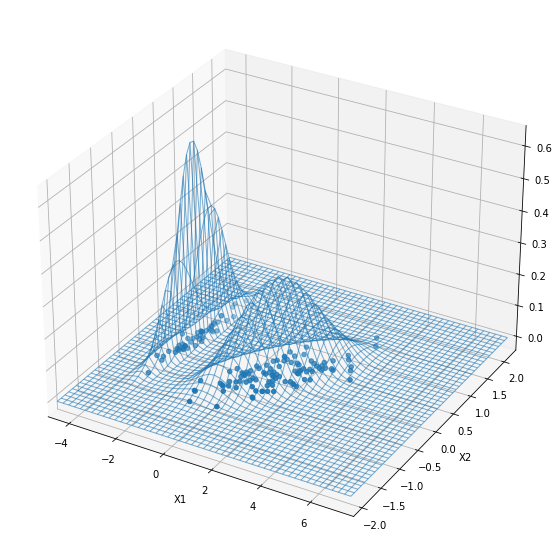

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal

def EM(A, k, eps, mu=None, cov=None, independent=False):

    centroids = []
    covariances = []
    if mu is None:
        centroids = [[random.choice(A[:, 0]), random.choice(A[:, 1])]
                     for x in range(k)]
    else:
        centroids = mu

    A_rows, A_cols = A.shape
    if cov is None:
        covariances = [np.identity(A_cols) for x in range(k)]
    else:
        covariances = cov

    prior_probs = [1/k for x in range(k)]

    w = np.empty([A_rows, k])
    while True:
        total = 0
        old_centroids = centroids

        for j, punto in enumerate(A):

            wij_arriba = [multivariate_normal.pdf(
                punto, mean=centroids[a], cov=covariances[a]) * prior_probs[a] for a in range(k)]

            for i in range(k):
                w[j, i] = wij_arriba[i] / np.sum(wij_arriba)

        centroids = []
        prior_probs = []
        for i in range(0, k):
            muti_arriba = 0
            muti_abajo = 0
            covi_arriba = 0
            centroid_prob = []
            for j in range(0, A_rows):
                punto = np.array(A[j])

                muti_arriba += (w[j, i]*punto)
                muti_abajo += w[j, i]
                muti = muti_arriba/muti_abajo

                covi_arriba += w[j, i]*(punto-muti)*((punto-muti).T)
            covi = covi_arriba/muti_abajo

            pti = muti_abajo/A_rows
            centroids.append(muti)
            np.fill_diagonal(covariances[i], covi)
            prior_probs.append(pti)

        if independent == False:
            cov_nuevo = np.zeros([A_cols, A_cols])
            covab_abajo = np.sum(w, axis=0)
            for i in range(0, k):
                covab = 0
                covab_arriba = 0
                covab_arriba = np.sum(np.array(
                    [w[j, i] * np.outer(punto-centroids[i], punto-centroids[i]) for j, punto in enumerate(A)]), axis=0)
                covab = covab_arriba/covab_abajo[i]

                covariances[i] = covab

        for s in range(k):
            total += (centroids[s] - old_centroids[s])**2
        if (total[0] <= eps and total[1] <= eps):
            break
    return w, centroids, covariances, prior_probs

#%matplotlib notebook
Iris_pca = pd.read_csv("iris_pca.csv").values
mu_init = [np.array(mu) for mu in [[-3.59, 0.25], [-1.09, -0.46], [0.75, 1.07]]]
cov_init = [np.eye(2) for i in range(3)]
probs, mu, cov, P = EM(Iris_pca, 3, 0.001, mu=mu_init, cov=cov_init, independent=False)
print(np.round(mu, 2), np.round(cov, 2), np.round(P, 2))
plot_gaussian_mixture(mu, cov, P, Iris_pca)

### Independent

[[-2.64  0.19]
 [ 0.41 -0.52]
 [ 1.85  0.15]] [[[0.05 0.  ]
  [0.   0.2 ]]

 [[0.38 0.  ]
  [0.   0.08]]

 [[0.63 0.  ]
  [0.   0.13]]] [0.33 0.24 0.42]


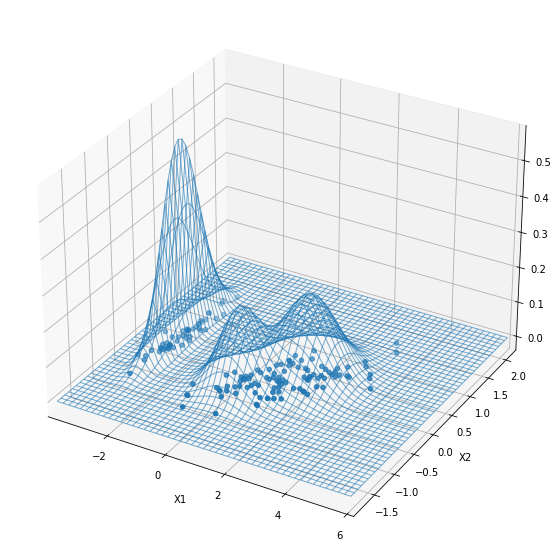

In [ ]:
#%matplotlib notebook
Iris_pca = pd.read_csv("iris_pca.csv").values
mu_init = [np.array(mu) for mu in [[-3.59, 0.25], [-1.09, -0.46], [0.75, 1.07]]]
cov_init = [np.eye(2) for i in range(3)]
probs, mu, cov, P = EM(Iris_pca, 3, 0.001, mu=mu_init, cov=cov_init, independent=True)
print(np.round(mu, 2), np.round(cov, 2), np.round(P, 2))
plot_gaussian_mixture(mu, cov, P, Iris_pca)